# Fitting Polynomial Regression Models

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy.stats import loguniform, uniform

from sklearn.datasets import fetch_california_housing
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, SGDRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, ShuffleSplit, validation_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore")
np.random.seed(306)

In [5]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

In [6]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels, random_state=42)
train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state=42)

## Fitting `LinearRegression()` 
Using `standardScaler()` in a pipeline

In [10]:
lg_pipeline = Pipeline([('feature_scaling', StandardScaler()),
         ('lg', LinearRegression())])
lg_results = cross_validate(lg_pipeline, com_train_features, com_train_labels, cv=cv, scoring='neg_mean_absolute_error', 
                            return_train_score=True, return_estimator=True)

lg_train_error = -1 * lg_results['train_score']
lg_test_error = -1 * lg_results['test_score']

print("Traning Error Mean : ", lg_train_error.mean())
print("Traning Error Standard Deviation : ", lg_train_error.std())

print("\nTest Error Mean : ", lg_test_error.mean())
print("Test Error Standard Deviation : ", lg_test_error.std())

Traning Error Mean :  0.5304021630418913
Traning Error Standard Deviation :  0.0023212935286191067

Test Error Mean :  0.5270142316974493
Test Error Standard Deviation :  0.007781288307852386


## Fitting `SGDRegression()` 
Using `standardScaler()` in a pipeline

In [16]:
max_iter = np.ceil(1e6/com_train_features.shape[0])
sgd_pipeline = Pipeline([('feature_scaling', StandardScaler()),
                        ('sgd', SGDRegressor(max_iter=max_iter, early_stopping=True, 
                                             eta0=1e-4, learning_rate='constant', tol=1e-5, validation_fraction=0.1, 
                                             n_iter_no_change=5, average=10, random_state=42))])

sgd_results = cross_validate(sgd_pipeline, com_train_features, com_train_labels, cv=cv, scoring='neg_mean_absolute_error',
                            return_train_score=True, return_estimator=True)

sgd_train_error = -1 * sgd_results['train_score']
sgd_test_error = -1 * sgd_results['test_score']  # Note that this is actually validation set (set to 10% of com_train)

print("Traning Error Mean : ", sgd_train_error.mean())
print("Traning Error Standard Deviation : ", sgd_train_error.std())

print("\nTest Error Mean : ", sgd_test_error.mean())
print("Test Error Standard Deviation : ", sgd_test_error.std())

Traning Error Mean :  0.5341022234609116
Traning Error Standard Deviation :  0.012509661906015553

Test Error Mean :  0.5303914597626358
Test Error Standard Deviation :  0.009578217711434925


**Both errors are close, but not exactly low. So, let's perform polynomial regression on them**

In [17]:
poly_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2)),
    ('feature_scaling', StandardScaler()),
    ('lg', LinearRegression())
])

poly_results = cross_validate(poly_pipeline, com_train_features, com_train_labels, cv=cv, scoring='neg_mean_absolute_error',
                            return_train_score=True, return_estimator=True)

poly_train_error = -1 * poly_results['train_score']
poly_test_error = -1 * poly_results['test_score']

print("Traning Error Mean : ", poly_train_error.mean())
print("Traning Error Standard Deviation : ", poly_train_error.std())

print("\nTest Error Mean : ", poly_test_error.mean())
print("Test Error Standard Deviation : ", poly_test_error.std())

Traning Error Mean :  0.4609643523643531
Traning Error Standard Deviation :  0.0029770810387742958

Test Error Mean :  0.48544599478539574
Test Error Standard Deviation :  0.030312417310768416


**Now, let's apply only interaction features after applying polynomial features**

- The interaction features are features that are products of at most `degree` *distinct* input features, i.e. terms with power of 2 or higher of the same input feature are excluded:

    Included : $x_{0}$ , $x_{1}$, $x_{0}x_{1}$, etc <br>
    Excluded: $x_{0}^2$,  $x_{0}^2x_{1}$, etc.



In [18]:
poly_pipeline = Pipeline([('poly', PolynomialFeatures(degree=2, interaction_only=True)),
                        ('feature_scaling', StandardScaler()),
                        ('lg', LinearRegression())])

poly_results = cross_validate(poly_pipeline, com_train_features, com_train_labels, cv=cv, scoring='neg_mean_absolute_error',
                            return_train_score=True, return_estimator=True)

poly_train_error = -1 * poly_results['train_score']
poly_test_error = -1 * poly_results['test_score']


print("Traning Error Mean : ", poly_train_error.mean())
print("Traning Error Standard Deviation : ", poly_train_error.std())

print("\nTest Error Mean : ", poly_test_error.mean())
print("Test Error Standard Deviation : ", poly_test_error.std())

Traning Error Mean :  0.47781943309759045
Traning Error Standard Deviation :  0.002820194504598875

Test Error Mean :  0.49687156934590904
Test Error Standard Deviation :  0.024386511812483087


**Now, let's use `validation_curve` and find the polynomial degree that would yield the least error**

In [21]:
degree = [1,2,3,4,5]
train_scores, test_scores = validation_curve(poly_pipeline, com_train_features, com_train_labels, param_name='poly__degree', 
                 param_range=degree, cv=cv, scoring='neg_mean_absolute_error')
train_errors, test_errors = -train_scores, -test_scores

Text(0.5, 1.0, 'Validation curve for polynomial regression')

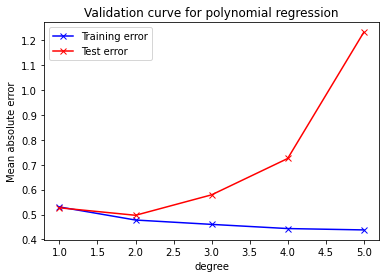

In [22]:
plt.plot(degree, train_errors.mean(axis=1), 'b-x', label='Training error')
plt.plot(degree, test_errors.mean(axis=1), 'r-x', label='Test error')
plt.legend()

plt.xlabel('degree')
plt.ylabel('Mean absolute error')
plt.title('Validation curve for polynomial regression')

From the above graph, it's clear that the **least error occurs degree 2**

## Polynomial models tend to overfit. So, let's apply a regularization

### Ridge Regularization

In [24]:
ridge_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('feature_scaling', StandardScaler()),
    ('ridge', Ridge(alpha=0.5))
])

ridge_results = cross_validate(ridge_pipeline, com_train_features, com_train_labels, cv=cv, scoring='neg_mean_absolute_error',
                            return_train_score=True, return_estimator=True)

ridge_train_error = -1 * ridge_results['train_score']
ridge_test_error = -1 * ridge_results['test_score']


print("Traning Error Mean : ", ridge_train_error.mean())
print("Traning Error Standard Deviation : ", ridge_train_error.std())

print("\nTest Error Mean : ", ridge_test_error.mean())
print("Test Error Standard Deviation : ", ridge_test_error.std())

Traning Error Mean :  0.4805687523496033
Traning Error Standard Deviation :  0.003485200424378284

Test Error Mean :  0.48669297649034704
Test Error Standard Deviation :  0.0056520049057814615


#### Find the best alpha (ridge regularization rate) using RidgeCV.

In [27]:
alpha_list = np.logspace(-4, 0, num=20)
alpha_list

array([1.00000000e-04, 1.62377674e-04, 2.63665090e-04, 4.28133240e-04,
       6.95192796e-04, 1.12883789e-03, 1.83298071e-03, 2.97635144e-03,
       4.83293024e-03, 7.84759970e-03, 1.27427499e-02, 2.06913808e-02,
       3.35981829e-02, 5.45559478e-02, 8.85866790e-02, 1.43844989e-01,
       2.33572147e-01, 3.79269019e-01, 6.15848211e-01, 1.00000000e+00])

In [28]:
ridge_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('feature_scaling', StandardScaler()),
    ('ridge', RidgeCV(alphas=alpha_list, cv=cv, scoring='neg_mean_absolute_error'))
])

ridge_cv_results = ridge_pipeline.fit(com_train_features, com_train_labels)
ridge_cv_results

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('feature_scaling', StandardScaler()),
                ('ridge',
                 RidgeCV(alphas=array([1.00000000e-04, 1.62377674e-04, 2.63665090e-04, 4.28133240e-04,
       6.95192796e-04, 1.12883789e-03, 1.83298071e-03, 2.97635144e-03,
       4.83293024e-03, 7.84759970e-03, 1.27427499e-02, 2.06913808e-02,
       3.35981829e-02, 5.45559478e-02, 8.85866790e-02, 1.43844989e-01,
       2.33572147e-01, 3.79269019e-01, 6.15848211e-01, 1.00000000e+00]),
                         cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
                         scoring='neg_mean_absolute_error'))])

In [29]:
print("Score with the best aplha : ", ridge_cv_results[-1].best_score_)
print("Best value of alpha is : ", ridge_cv_results[-1].alpha_)

Score with the best aplha :  -0.4729407010085872
Best value of alpha is :  0.007847599703514606


#### Find the best alpha (ridge regularization rate) using GridSearchCV.

In [46]:
ridge_grid_pipeline = Pipeline([('poly', PolynomialFeatures(degree=2)),
                        ('feature_scaling', StandardScaler()),
                        ('ridge', Ridge())])

param_grid = {'poly__degree': (1,2,3),
             'ridge__alpha': np.logspace(-4, 0, num=20)}

ridge_grid_search = GridSearchCV(ridge_grid_pipeline, param_grid=param_grid, cv=cv, scoring='neg_mean_absolute_error', return_train_score=True)
ridge_grid_search.fit(com_train_features, com_train_labels)
ridge_grid_search.best_index_

mean_train_error = -1 * ridge_grid_search.cv_results_['mean_train_score'][ridge_grid_search.best_index_]
std_train_error = ridge_grid_search.cv_results_['std_train_score'][ridge_grid_search.best_index_]
mean_test_error = -1 * ridge_grid_search.cv_results_['mean_test_score'][ridge_grid_search.best_index_]
std_test_error = ridge_grid_search.cv_results_['std_test_score'][ridge_grid_search.best_index_]


print("Traning Error Mean : ", mean_train_error)
print("Traning Error Standard Deviation : ", std_train_error)

print("\nTest Error Mean : ", mean_test_error)
print("Test Error Standard Deviation : ", std_test_error)

print("\nBest value of hyper-parameters are : ", ridge_grid_search.best_params_)
print("\nBest value of score is : ", ridge_grid_search.best_score_)

### Lasso Regularization

In [47]:
lasso_pipeline = Pipeline([('poly', PolynomialFeatures(degree=2)),
                        ('feature_scaling', StandardScaler()),
                        ('lasso', Lasso(alpha=0.01))])  # alpha is the regularization rate

lasso_results = cross_validate(lasso_pipeline, com_train_features, com_train_labels, cv=cv, scoring='neg_mean_absolute_error',
                            return_train_score=True, return_estimator=True)

lasso_train_error = -1 * lasso_results['train_score']
lasso_test_error = -1 * lasso_results['test_score']


print("Traning Error Mean : ", lasso_train_error.mean())
print("Traning Error Standard Deviation : ", lasso_test_error.std())

print("\nTest Error Mean : ", lasso_train_error.mean())
print("Test Error Standard Deviation : ", lasso_test_error.std())

Traning Error Mean :  0.5293087458828422
Traning Error Standard Deviation :  0.007894893222386748

Test Error Mean :  0.5293087458828422
Test Error Standard Deviation :  0.007894893222386748


LassoCV uses a different approach than RidgeCV, so we are not using it here.

#### Find the best alpha (lasso regularization rate) using GridSearchCV.

In [49]:
lasso_grid_pipeline = Pipeline([('poly', PolynomialFeatures(degree=2)),
                        ('feature_scaling', StandardScaler()),
                        ('lasso', Lasso())])

param_grid = {'poly__degree': (1,2,3),
             'lasso__alpha': np.logspace(-4, 0, num=20)}

lasso_grid_search = GridSearchCV(lasso_grid_pipeline, param_grid=param_grid, cv=cv, scoring='neg_mean_absolute_error', return_train_score=True)
lasso_grid_search.fit(com_train_features, com_train_labels)
lasso_grid_search.best_index_

In [ ]:
mean_train_error = -1 * lasso_grid_search.cv_results_['mean_train_score'][lasso_grid_search.best_index_]
std_train_error = lasso_grid_search.cv_results_['std_train_score'][lasso_grid_search.best_index_]
mean_test_error = -1 * lasso_grid_search.cv_results_['mean_test_score'][lasso_grid_search.best_index_]
std_test_error = lasso_grid_search.cv_results_['std_test_score'][lasso_grid_search.best_index_]

In [ ]:
print("Traning Error Mean : ", mean_train_error)
print("Traning Error Standard Deviation : ", std_train_error)

print("\nTest Error Mean : ", mean_test_error)
print("Test Error Standard Deviation : ", std_test_error)

print("\nBest value of hyper-parameters are : ", lasso_grid_search.best_params_)
print("\nBest value of score is : ", lasso_grid_search.best_score_)

## SGD Regularization

In [51]:
sgd_pipeline = Pipeline([('poly', PolynomialFeatures(degree=2)),
                        ('feature_scaling', StandardScaler()),
                        ('sgd', SGDRegressor(penalty='elasticnet', random_state=42))])

sgd_results = cross_validate(sgd_pipeline, com_train_features, com_train_labels, cv=cv, scoring='neg_mean_absolute_error',
                            return_train_score=True, return_estimator=True)

sgd_train_error = -1 * sgd_results['train_score']
sgd_test_error = -1 * sgd_results['test_score']

print("Traning Error Mean : ", sgd_train_error.mean())
print("Traning Error Standard Deviation : ", sgd_train_error.std())

print("\nTest Error Mean : ", sgd_test_error.mean())
print("Test Error Standard Deviation : ", sgd_test_error.std())

Traning Error Mean :  10824283052.546406
Traning Error Standard Deviation :  4423288211.831954

Test Error Mean :  10946788540.249529
Test Error Standard Deviation :  5396536227.702746


#### Find the best parameters of polynomial + SGD regression using RandomizedSearchCV.

In [ ]:
sgd_pipeline = Pipeline([('poly', PolynomialFeatures(degree=2)),
                        ('feature_scaling', StandardScaler()),
                        ('sgd', SGDRegressor(penalty='elasticnet', random_state=42))])

param_distributions = {'poly__degree': (1,2,3),
              'sgd__learning_rate': ['constant', 'adaptive', 'invscaling'],
             'sgd__l1_ratio': uniform(0,1),
              'sgd__eta0': loguniform(1e-5, 1),
              'sgd__power_t': uniform(0,1)
}

poly_sgd_random_search = RandomizedSearchCV(sgd_pipeline, param_distributions=param_distributions, n_iter=10, cv=cv, scoring='neg_mean_absolute_error')
poly_sgd_random_search.fit(com_train_features, com_train_labels)

print("\nBest value of hyper-parameters are : ", poly_sgd_random_search.best_params_)
print("\nBest value of score is : ", poly_sgd_random_search.best_score_)

## Comparision of Weight Vectors

In [52]:
feature_names = poly_results['estimator'][0][0].get_feature_names_out(input_features=train_features.columns)
feature_names

array(['1', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude', 'MedInc HouseAge',
       'MedInc AveRooms', 'MedInc AveBedrms', 'MedInc Population',
       'MedInc AveOccup', 'MedInc Latitude', 'MedInc Longitude',
       'HouseAge AveRooms', 'HouseAge AveBedrms', 'HouseAge Population',
       'HouseAge AveOccup', 'HouseAge Latitude', 'HouseAge Longitude',
       'AveRooms AveBedrms', 'AveRooms Population', 'AveRooms AveOccup',
       'AveRooms Latitude', 'AveRooms Longitude', 'AveBedrms Population',
       'AveBedrms AveOccup', 'AveBedrms Latitude', 'AveBedrms Longitude',
       'Population AveOccup', 'Population Latitude',
       'Population Longitude', 'AveOccup Latitude', 'AveOccup Longitude',
       'Latitude Longitude'], dtype=object)

In [53]:
coefs = [est[-1].coef_ for est in poly_results['estimator']]
weights_polynomial_regression = pd.DataFrame(coefs, columns=feature_names)

Text(0.5, 1.0, 'Polynomial regression coefficients')

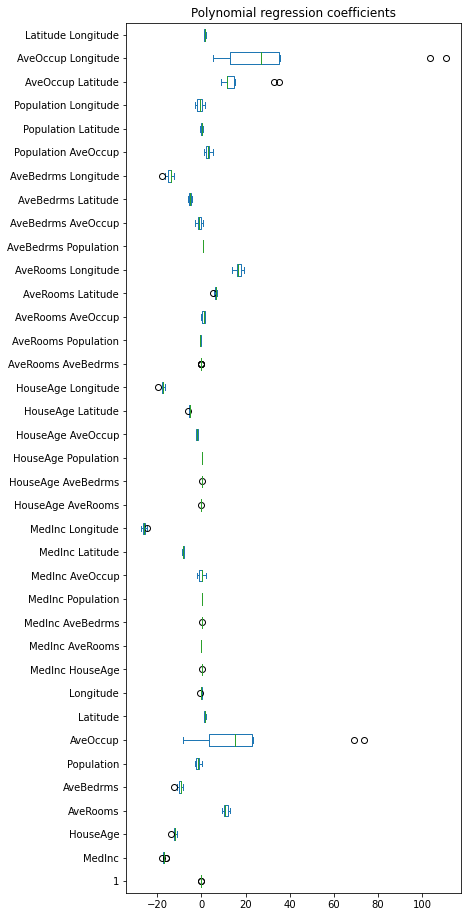

In [54]:
weights_polynomial_regression.plot.box(vert=False, figsize=(6,16))
plt.title("Polynomial regression coefficients")

From the above box plot, it looks like the weights given to *AveOccup* and *AveOccupLongitude* have **outliers**. So, plot them for the ridge regression

In [55]:
feature_names = ridge_results['estimator'][0][0].get_feature_names_out(input_features=train_features.columns)
feature_names

array(['1', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude', 'MedInc^2', 'MedInc HouseAge',
       'MedInc AveRooms', 'MedInc AveBedrms', 'MedInc Population',
       'MedInc AveOccup', 'MedInc Latitude', 'MedInc Longitude',
       'HouseAge^2', 'HouseAge AveRooms', 'HouseAge AveBedrms',
       'HouseAge Population', 'HouseAge AveOccup', 'HouseAge Latitude',
       'HouseAge Longitude', 'AveRooms^2', 'AveRooms AveBedrms',
       'AveRooms Population', 'AveRooms AveOccup', 'AveRooms Latitude',
       'AveRooms Longitude', 'AveBedrms^2', 'AveBedrms Population',
       'AveBedrms AveOccup', 'AveBedrms Latitude', 'AveBedrms Longitude',
       'Population^2', 'Population AveOccup', 'Population Latitude',
       'Population Longitude', 'AveOccup^2', 'AveOccup Latitude',
       'AveOccup Longitude', 'Latitude^2', 'Latitude Longitude',
       'Longitude^2'], dtype=object)

In [56]:
coefs = [est[-1].coef_ for est in ridge_results['estimator']]
weights_ridge_regression = pd.DataFrame(coefs, columns=feature_names)

Text(0.5, 1.0, 'Ridge regression coefficients')

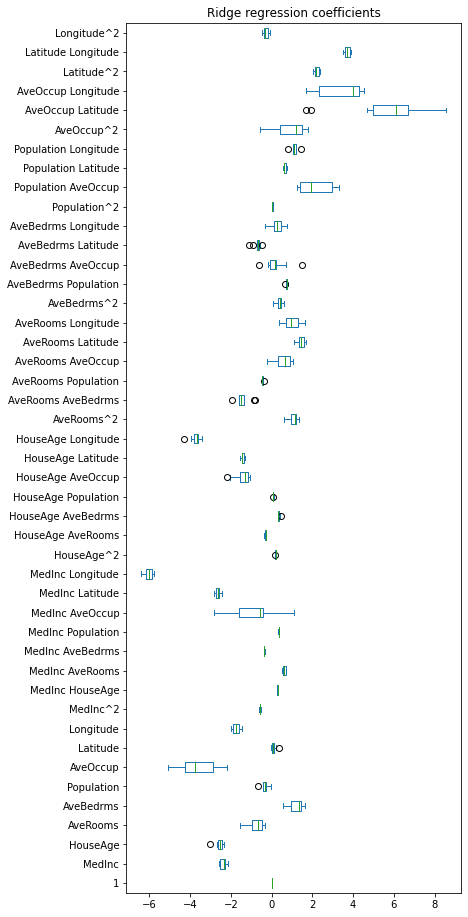

In [57]:
weights_ridge_regression.plot.box(vert=False, figsize=(6,16))
plt.title("Ridge regression coefficients")

## Performance on Test Set
Do the following first :
- Run Polynomial SGD with RandomSearchCV
- Run Ridge with GridSearchCV
- Run Lasso with GridSearchCV

I haven't executed the above 3 parts but upon doing so, we get the least error from the **ridge regression model obtained from the GridSearchCV**

In [58]:
baseline_model_median = DummyRegressor(strategy='median')
baseline_model_median.fit(train_features, train_labels)
mean_absolute_percentage_error(test_labels, baseline_model_median.predict(test_features))

0.5348927548151625

In [59]:
mean_absolute_percentage_error(test_labels, lg_results['estimator'][0].predict(test_features))

0.32120472175482906

In [61]:
mean_absolute_percentage_error(test_labels, poly_sgd_random_search.best_estimator_.predict(test_features))

In [62]:
mean_absolute_percentage_error(test_labels, poly_results['estimator'][0].predict(test_features))

0.2834129629962932

In [63]:
mean_absolute_percentage_error(test_labels, ridge_results['estimator'][0].predict(test_features))

0.29207715093905434

In [67]:
mean_absolute_percentage_error(test_labels, ridge_grid_search.best_estimator_.predict(test_features))

In [69]:
mean_absolute_percentage_error(test_labels, lasso_grid_search.best_estimator_.predict(test_features))